## AIS Analyze Vessel Clusters

In [1]:
# from IPython.display import Image, HTML
import os
import numpy as np
import pandas as pd
import datetime
import warnings
from glob import glob

warnings.filterwarnings("ignore")           # Suppress Warning

In [2]:
WorkingFolder = "/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS_Processed/"

In [3]:
OutputDir = "/Users/cv0361/Desktop/TechChallenge/Data/csv/ValidAIS/"

### Load Broadcast Data

In [7]:
folder = WorkingFolder + "Zone03_2017_01/"

Broadcast = pd.read_csv("/Users/cv0361/Desktop/TechChallenge/Data/csv/AIS/AIS_2017_01_Zone03.csv", sep=",")
Broadcast.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,564294000,2017-01-01T00:00:00,54.47611,-167.27802,10.1,-130.7,274.0,PEGASUS OCEAN,IMO9736963,9V2597,1004.0,under way using engine,174.53,NaN,NaN,NaN
1,564294000,2017-01-01T00:02:10,54.47709,-167.28815,10.0,-132.3,273.0,PEGASUS OCEAN,IMO9736963,9V2597,1004.0,under way using engine,174.53,NaN,NaN,NaN
2,367373760,2017-01-01T00:03:41,53.87792,-166.54954,0.0,-104.7,324.0,NORTH SEA,IMO7915905,WDE5954,1001.0,undefined,37.32,9.56,NaN,NaN
3,367094420,2017-01-01T00:04:44,53.87947,-166.54099,0.0,-126.7,511.0,ARCTIC MARINER,IMO7926605,WDC8874,1001.0,under way using engine,31.00,9.28,NaN,30.0
4,564294000,2017-01-01T00:06:50,54.47952,-167.30954,9.4,-124.5,276.0,PEGASUS OCEAN,IMO9736963,9V2597,1004.0,under way using engine,174.53,NaN,NaN,NaN


In [8]:
print("Raw Count:", Broadcast.shape[0])

Raw Count: 2914245


### K-means
* https://github.com/JosephMagiya/Clustering-GPS-Co-ordinates--Forming-Regions./blob/master/Clustering-GPS-Co-ordinates--Forming-Regions.ipynb

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

In [83]:
# 367094420      ARCTIC MARINER 	 type: 1001 - Fishing, 31x9.28       lots of points
# 367565680      ADAMANT             type: 1001 - Fishing, 18x8          lots of points
# 367373760      NORTH SEA           type: 1001 - Fishing, 37x10
# 440102000      TORAH               type: 1004 - Freight, 115.8x16.62   lots of points
# 636014222      Zim Rotter          type: 1004 - Freight, 349x45.73
# 367322830      GYRFALCON           type: 1025 - Towing, 30.63x10.4     lots of points


mmsi = 367322830     

df = Broadcast.loc[Broadcast.MMSI==mmsi, ['BaseDateTime', 'LAT', 'LON']]
df.rename(columns={'LAT':'latitude', 'LON':'longitude'}, inplace=True)
X = df.loc[:,:]
df.head()

,BaseDateTime,latitude,longitude
136130,2017-01-03T05:57:41,55.01475,-162.01318
136145,2017-01-03T06:04:21,55.01302,-162.03377
136146,2017-01-03T06:12:41,55.01139,-162.05807
137368,2017-01-03T06:01:20,55.01364,-162.02439
137369,2017-01-03T06:18:01,55.01059,-162.07248


In [84]:
df.shape

(32198, 3)

In [85]:
df.describe()

,latitude,longitude
count,32198.000000,32198.000000
mean,53.923681,-166.457644
std,0.110180,0.411652
min,53.835920,-166.593440
25%,53.905350,-166.522560
50%,53.905360,-166.522550
75%,53.905390,-166.520840
max,55.015860,-162.001940


In [86]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

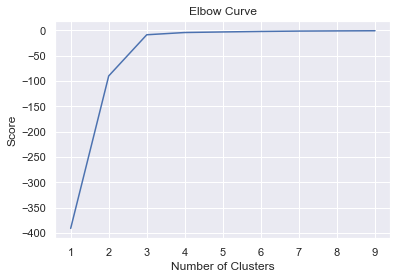

In [95]:
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [109]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')

X = df[df.columns[1:3]]
kmeans.fit(X)                                   # Compute k-means clustering. # Compute k-means clustering.

df['cluster_label'] = kmeans.predict(X)                      # Labels of each point

centers = kmeans.cluster_centers_               # Coordinates of cluster centers.
# labels = kmeans.predict(X)                      # Labels of each point

df.head()

,BaseDateTime,latitude,longitude,cluster_label
136130,2017-01-03T05:57:41,55.01475,-162.01318,1
136145,2017-01-03T06:04:21,55.01302,-162.03377,1
136146,2017-01-03T06:12:41,55.01139,-162.05807,1
137368,2017-01-03T06:01:20,55.01364,-162.02439,1
137369,2017-01-03T06:18:01,55.01059,-162.07248,1


In [106]:
X.head()

,latitude,longitude
136130,55.01475,-162.01318
136145,55.01302,-162.03377
136146,55.01139,-162.05807
137368,55.01364,-162.02439
137369,55.01059,-162.07248


In [107]:
centers

array([[  53.90467853, -166.52260432],
       [  54.9325743 , -162.44433498],
       [  54.1661893 , -165.76784167]])

In [108]:
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

In [104]:
# Cluster, ping counts
PingCluster = df.groupby('cluster_label').agg({'BaseDateTime': ['count']})

PingCluster

,BaseDateTime
,count
cluster_label,
0,30717
1,293
2,1188


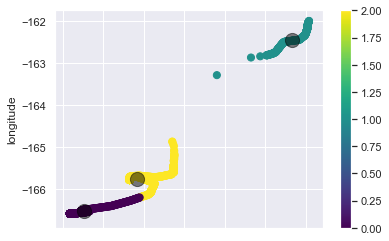

In [110]:
X.plot.scatter(x = 'latitude', y = 'longitude', c=df['cluster_label'], s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### Sample
* https://hdbscan.readthedocs.io/en/latest/advanced_hdbscan.html

In [26]:
from sklearn.datasets import make_blobs
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
blobs, labels = make_blobs(n_samples=2000, n_features=10)

In [8]:
pd.DataFrame(blobs).head()

,0,1,2,3,4,5,6,7,8,9
0,-1.264875,-8.260352,-7.672387,-4.457326,-2.654197,4.046740,4.732487,-8.031294,-3.358178,0.746357
1,-4.789295,5.347213,-9.076223,-2.658427,7.980381,6.582558,-2.511977,9.363582,9.516691,-6.797194
2,-8.840059,4.799937,-8.509396,1.783674,5.945335,-6.128442,-8.588533,-1.142080,8.091949,9.063377
3,-6.527711,5.229888,-8.250775,-0.308170,6.792324,5.278408,-1.254370,5.681781,9.835620,-6.410695
4,-8.316694,6.439864,-9.477828,-0.442857,4.329686,-4.317371,-8.836133,-2.024001,9.477133,8.406125


In [22]:
blobs.shape

(2000, 10)

In [23]:
blobs

array([[ -1.26487527,  -8.2603524 ,  -7.67238674, ...,  -8.03129446,
         -3.35817837,   0.74635706],
       [ -4.78929506,   5.34721314,  -9.0762227 , ...,   9.36358247,
          9.51669117,  -6.79719369],
       [ -8.84005935,   4.79993719,  -8.50939632, ...,  -1.14208   ,
          8.09194909,   9.06337698],
       ...,
       [ -1.48204497,  -7.86863968,  -8.58340059, ...,  -9.08749093,
         -2.90563069,  -1.05112635],
       [ -1.86398912,  -9.04289069,  -8.43069477, ..., -10.74356022,
         -2.72570248,   0.7149232 ],
       [ -3.82640572,   5.8166833 ,  -8.18621666, ...,   6.85105027,
          9.21200197,  -7.92391158]])

In [34]:
data = blobs.T[:,0:2]

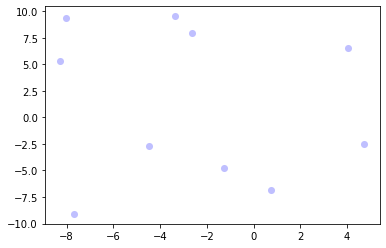

In [35]:
plt.scatter(*data.T, s=50, linewidth=0, c='b', alpha=0.25)

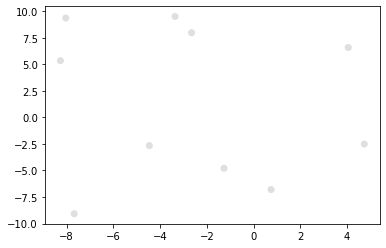

In [36]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(data)
color_palette = sns.color_palette('deep', 8)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*data.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [37]:
clusterer.condensed_tree_

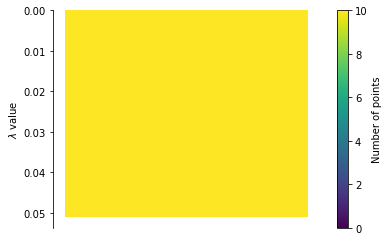

In [38]:
clusterer.condensed_tree_.plot()

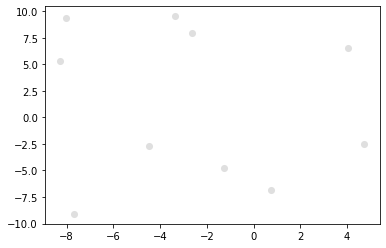

In [39]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]
plt.scatter(*data.T, s=50, linewidth=0, c='gray', alpha=0.25)
plt.scatter(*data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)

In [32]:
blobs.T[:,0:2].shape

(10, 2)

In [10]:
clusterer = hdbscan.HDBSCAN()

In [11]:
clusterer.fit(blobs)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

In [24]:
len(clusterer.labels_)

2000

In [12]:
clusterer.labels_

array([0, 1, 2, ..., 0, 0, 1])

In [13]:
clusterer.labels_.max()

2

In [14]:
clusterer.probabilities_

array([0.65203928, 0.80439755, 0.82601858, ..., 1.        , 0.62995029,
       0.62921136])

In [15]:
clusterer = hdbscan.HDBSCAN(metric='manhattan')
clusterer.fit(blobs)
clusterer.labels_

array([0, 1, 2, ..., 0, 0, 1])

In [16]:
hdbscan.dist_metrics.METRIC_MAPPING

{'euclidean': hdbscan.dist_metrics.EuclideanDistance,
 'l2': hdbscan.dist_metrics.EuclideanDistance,
 'minkowski': hdbscan.dist_metrics.MinkowskiDistance,
 'p': hdbscan.dist_metrics.MinkowskiDistance,
 'manhattan': hdbscan.dist_metrics.ManhattanDistance,
 'cityblock': hdbscan.dist_metrics.ManhattanDistance,
 'l1': hdbscan.dist_metrics.ManhattanDistance,
 'chebyshev': hdbscan.dist_metrics.ChebyshevDistance,
 'infinity': hdbscan.dist_metrics.ChebyshevDistance,
 'seuclidean': hdbscan.dist_metrics.SEuclideanDistance,
 'mahalanobis': hdbscan.dist_metrics.MahalanobisDistance,
 'wminkowski': hdbscan.dist_metrics.WMinkowskiDistance,
 'hamming': hdbscan.dist_metrics.HammingDistance,
 'canberra': hdbscan.dist_metrics.CanberraDistance,
 'braycurtis': hdbscan.dist_metrics.BrayCurtisDistance,
 'matching': hdbscan.dist_metrics.MatchingDistance,
 'jaccard': hdbscan.dist_metrics.JaccardDistance,
 'dice': hdbscan.dist_metrics.DiceDistance,
 'kulsinski': hdbscan.dist_metrics.KulsinskiDistance,
 'rogerst

In [17]:
from sklearn.metrics.pairwise import pairwise_distances

In [18]:
distance_matrix = pairwise_distances(blobs)

In [19]:
distance_matrix

array([[ 0.        , 30.00083681, 29.50051889, ...,  3.55500992,
         4.3568916 , 29.92376286],
       [30.00083681,  0.        , 24.56326019, ..., 29.60063764,
        32.27173609,  5.39005198],
       [29.50051889, 24.56326019,  0.        , ..., 30.14754856,
        30.84141333, 23.7567574 ],
       ...,
       [ 3.55500992, 29.60063764, 30.14754856, ...,  0.        ,
         4.06465649, 29.23320791],
       [ 4.3568916 , 32.27173609, 30.84141333, ...,  4.06465649,
         0.        , 31.76605252],
       [29.92376286,  5.39005198, 23.7567574 , ..., 29.23320791,
        31.76605252,  0.        ]])

In [20]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(distance_matrix)
clusterer.labels_

array([0, 2, 1, ..., 0, 0, 2])